In [1]:
import os, sys, time
sys.path.insert(0, "..")

import torch
import matplotlib.pyplot as plt
import numpy as np
from src.pinns import PINN
from src.utils.visualization import TrainingDataVisualizer as TDV

In [2]:
# reproducibility
torch.manual_seed(31)

In [3]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch.autograd as autograd
# Example 1: 2D p-poisson equation
def pde_residual(coords, u_pred):
    """
    Compute the residual of the 2D p-Laplacian Poisson equation

        −∇·( |∇u|^(p-2) ∇u ) = 1

    Args:
        coords (torch.Tensor): shape (N,2) input points (x,y), requires_grad=True
        u_pred (torch.Tensor): shape (N,1) model's predicted u at coords

    Returns:
        torch.Tensor: PDE residual r(x,y) = −∇·( |∇u|^(p-2) ∇u ) - 1
    """
    p = 2.0  # p-Laplacian exponent
    # 1) Compute gradient ∇u = (∂u/∂x, ∂u/∂y)
    u_grad = autograd.grad(
        outputs=u_pred,
        inputs=coords,
        grad_outputs=torch.ones_like(u_pred).to(device),
        retain_graph=True,
        create_graph=True
    )[0]
    u_grad_x = u_grad[:, 0]
    u_grad_y = u_grad[:, 1]

    # 2) Compute |∇u|^(p−2)
    grad_norm_power = (u_grad_x**2 + u_grad_y**2)**((p - 2) / 2)

    # 3) Form flux q = |∇u|^(p−2) ∇u
    flux_x = grad_norm_power * u_grad_x
    flux_y = grad_norm_power * u_grad_y

    # 4) Compute divergence ∇·q = ∂q_x/∂x + ∂q_y/∂y
    div_q_x = autograd.grad(
        outputs=flux_x,
        inputs=coords,
        grad_outputs=torch.ones_like(flux_x).to(device),
        retain_graph=True,
        create_graph=True
    )[0][:, 0]
    div_q_y = autograd.grad(
        outputs=flux_y,
        inputs=coords,
        grad_outputs=torch.ones_like(flux_y).to(device),
        retain_graph=True,
        create_graph=True
    )[0][:, 1]

    p_laplacian = div_q_x + div_q_y

    # 5) PDE residual: −∇·( |∇u|^(p−2) ∇u ) − 1
    return -p_laplacian - 1


In [5]:
# 2) instantiate PINN
model = PINN(
    pde_residual=pde_residual,
    input_dim=2,
    hidden_dim=50,
    output_dim=1,
    num_hidden_layers=4,
    device=device,
    Nd=50, # number of boundary points
    Nc=1000, # number of collocation points
    optimizer_type = "adam",
    lr = 1e-4,
)
model.double()  # convert model to double precision
model.to(device)
print("Using device:", next(model.parameters()).device)


Using device: cpu


In [6]:
# grab the data generated in PINN.__init__
x_train_Nu = model.x_train_Nu
u_train_Nu = model.u_train_Nu
x_train_Nf = model.x_train_Nf

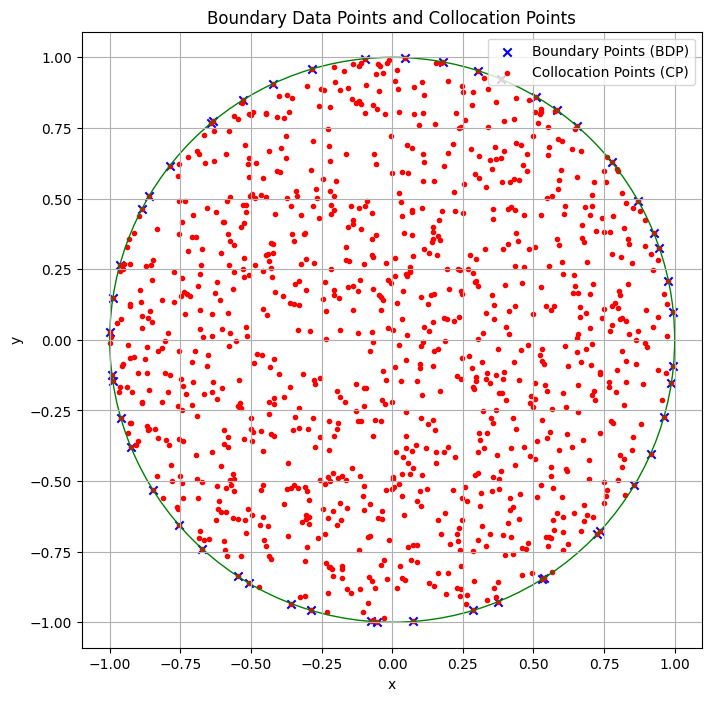

In [7]:
TDV.training_data_plot(x_train_Nu, x_train_Nf)

In [8]:
pi = torch.tensor(np.pi, dtype=torch.float).to(device)

In [9]:
epochs = 0
loss_values1 = 1
loss_values2 = 1
error = 1
loss_values = []

In [10]:
start_time = time.time()
while loss_values2 > 1e-4:
    loss = model(bc_weight=10)
    loss_values.append(loss.item())

    if epochs == 0:
        print("Training Loss ----- Test Loss")
        loss_values1 = 1
        loss_values2 = loss_values[0]
    else:
        loss_values1 = loss_values[epochs-1]
        loss_values2 = loss_values[epochs]
    error = ((loss_values2 - loss_values1)**2)
    if epochs % 500 == 0:
        print(epochs,'-',loss)

    epochs += 1

c:\Users\gh_ab\PINNs\notebooks\..\src\training\losses.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(x_train_Nf, dtype=torch.float64, device=device)
c:\Users\gh_ab\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1050, 1])) that is different to the input size (torch.Size([1050])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training Loss ----- Test Loss
0 - tensor(1.0268, dtype=torch.float64, grad_fn=<AddBackward0>)
500 - tensor(0.0087, dtype=torch.float64, grad_fn=<AddBackward0>)
1000 - tensor(0.0004, dtype=torch.float64, grad_fn=<AddBackward0>)
1500 - tensor(0.0003, dtype=torch.float64, grad_fn=<AddBackward0>)
2000 - tensor(0.0002, dtype=torch.float64, grad_fn=<AddBackward0>)
2500 - tensor(0.0002, dtype=torch.float64, grad_fn=<AddBackward0>)
3000 - tensor(0.0001, dtype=torch.float64, grad_fn=<AddBackward0>)
3500 - tensor(0.0001, dtype=torch.float64, grad_fn=<AddBackward0>)
4000 - tensor(0.0001, dtype=torch.float64, grad_fn=<AddBackward0>)


In [11]:
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

Training time: 209.96


In [12]:
from datetime import datetime
model_state = model.state_dict()
torch.save(model_state, 'model_stateadam.pth')

In [13]:
from datetime import datetime

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
optimizer_type = getattr(model.optimizer, "optimizer_type", "adam")
save_dir = "../saved_model"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"{optimizer_type}-{current_time}.pt")
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to ../saved_model\adam-20250517-172332.pt


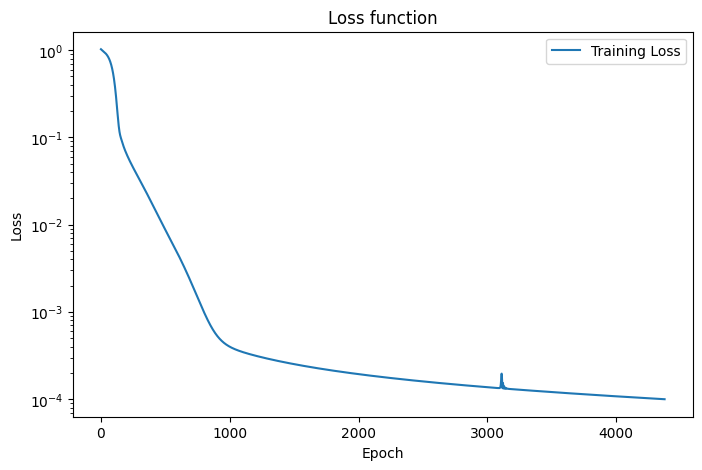

In [14]:
plt.figure(figsize=(8, 5))
plt.title("Loss function")
plt.semilogy(loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()